# Recurrent Neural Networks

- Sequence data
- Natural Language
- Speech ...

### RNN model
![](http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png)

### RNN example
![](http://karpathy.github.io/assets/rnn/diags.jpeg)

### LSTM (Long Short-Term Memory models)
![](https://i.ytimg.com/vi/kMLl-TKaEnc/maxresdefault.jpg)



## 그래서? 

1. 주가예측
  - tensorflow를 이용한 주가예측
  - keras를 이용한 주가예측
2. 감성분석

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import urllib
import os

/Users/chjeong/.pyenv/versions/3.6.3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# S&P 500
FILE_NAME    = 'all_stocks_5yr.csv'
SOURCE_URL   = 'https://github.com/CNuge/kaggle-code/raw/master/stock_data/' 

# YAHOO
# FILE_NAME    = 'prices.csv'
# SOURCE_URL = 'https://www.kaggle.com/dgawlik/nyse/downloads/prices.csv/' 

# GOOGLE
# FILE_NAME    = 'trainset.csv'
# SOURCE_URL = 'https://www.kaggle.com/ptheru/googledta/downloads/trainset.csv/' 

!mkdir 'data'
filepath = './data/'+ FILE_NAME

mkdir: data: File exists


In [3]:
urllib.request.urlretrieve(SOURCE_URL, filepath)

('./data/all_stocks_5yr.csv', <http.client.HTTPMessage at 0x119da2c18>)

In [5]:
data = pd.read_csv('./data/all_stocks_5yr.csv')
cl = data[data['Name']=='MMM']

In [6]:
cl = cl[['close']].values

In [7]:
def set_data(cl):
    scl = MinMaxScaler()
    #Scale the data
    # pandas.__version__ < 0.23
    # cl = cl.reshape(cl.shape[0],1)

    # pandas.__version__ => 0.23
    # cl = cl.as_matrix()
    # cl = cl.reshape(cl.shape[0],1)

    cl = scl.fit_transform(cl)
    return cl

In [8]:
cl = set_data(cl)

In [9]:
def processData(data,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data[(i+lb),0])
    return np.array(X),np.array(Y)

In [10]:
X, y = processData(cl,7)
y = y.reshape(y.shape[0], 1)

In [12]:
y.shape

(1251, 1)

In [14]:
X_train,X_test = X[:int(X.shape[0]*0.80)],X[int(X.shape[0]*0.80):]
y_train,y_test = y[:int(y.shape[0]*0.80)],y[int(y.shape[0]*0.80):]
print(X_train.shape[0])
print(X_test.shape[0])
print(y_train.shape[0])
print(y_test.shape[0])


1000
251
1000
251


In [18]:
# train Parameters
seq_length = 7
data_dim = 1
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [19]:
X[0:5]

array([[[0.00580061],
        [0.00554564],
        [0.01090005],
        [0.00707547],
        [0.00656553],
        [0.00943396],
        [0.01548955]],

       [[0.00554564],
        [0.01090005],
        [0.00707547],
        [0.00656553],
        [0.00943396],
        [0.01548955],
        [0.00892402]],

       [[0.01090005],
        [0.00707547],
        [0.00656553],
        [0.00943396],
        [0.01548955],
        [0.00892402],
        [0.00618307]],

       [[0.00707547],
        [0.00656553],
        [0.00943396],
        [0.01548955],
        [0.00892402],
        [0.00618307],
        [0.01140999]],

       [[0.00656553],
        [0.00943396],
        [0.01548955],
        [0.00892402],
        [0.00618307],
        [0.01140999],
        [0.        ]]])

In [17]:
X_train.shape

(1000, 7, 1)

In [20]:
y_train.shape

(1000, 1)

In [21]:
# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))


In [22]:

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: X_train, Y: y_train})
        if i%100 == 0:
            print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: X_test})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: y_test, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    

[step: 0] loss: 67.4892578125
[step: 100] loss: 0.20808453857898712
[step: 200] loss: 0.20318767428398132
[step: 300] loss: 0.19729676842689514
[step: 400] loss: 0.1905817687511444
RMSE: 0.042088575661182404


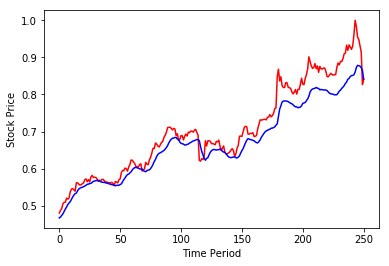

In [23]:
# Plot predictions
plt.plot(y_test, color='red')
plt.plot(test_predict, color='blue')
plt.xlabel("Time Period")
plt.ylabel("Stock Price")
plt.show()